<a href="https://colab.research.google.com/github/tariqmhmd5/Covid-Prediction/blob/master/Prophet_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from fbprophet import Prophet
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
print(tf.__version__)

2.2.0


In [0]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

na_columns = (confirmed_df.isna().sum() / confirmed_df.shape[0]) > 0.99
na_columns = na_columns[na_columns]

confirmed_df = confirmed_df.drop(na_columns.index, axis=1)
deaths_df = deaths_df.drop(na_columns.index, axis=1)
recoveries_df = recoveries_df.drop(na_columns.index, axis=1)

## Tidy up the data
confirmed_df = confirmed_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='confirmed')
deaths_df = deaths_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='deaths')
recoveries_df = recoveries_df.melt(id_vars=['Country/Region', 'Province/State', 'Lat', 'Long'], var_name='date', value_name='recoveries')

confirmed_df['date'] = pd.to_datetime(confirmed_df['date'])
deaths_df['date'] = pd.to_datetime(deaths_df['date'])
recoveries_df['date'] = pd.to_datetime(recoveries_df['date'])

full_df = confirmed_df.merge(recoveries_df).merge(deaths_df)
full_df = full_df.rename(columns={'Country/Region': 'Country', 'date': 'Date', 'confirmed': "Confirmed", "recoveries": "Recoveries", "deaths": "Deaths"})

df_india=full_df[full_df['Country']=='India']

world_df = full_df.groupby(['Date']).agg({'Confirmed': ['sum'], 'Recoveries': ['sum'], 'Deaths': ['sum']}).reset_index()
world_df.columns = world_df.columns.get_level_values(0)

def add_rates(df):
    df['Confirmed Change'] = df['Confirmed'].diff().shift(-1)
 
    df['Mortality Rate'] = df['Deaths'] / df['Confirmed']
    df['Recovery Rate'] = df['Recoveries'] / df['Confirmed']
    df['Growth Rate'] = df['Confirmed Change'] / df['Confirmed']
    df['Growth Rate Change'] = df['Growth Rate'].diff().shift(-1)
    df['Growth Rate Accel'] = df['Growth Rate Change'] / df['Growth Rate']
    return df

In [0]:
world_df = add_rates(world_df)
df_india=add_rates(df_india)
df_india=df_india[8:]
df_india.reset_index(inplace=True,drop=True)

In [0]:
df=pd.DataFrame(df_india[['Confirmed','Date']])

In [0]:
df.columns=['y','ds']

In [39]:
df.head()

,y,ds
0,1,2020-01-30
1,1,2020-01-31
2,1,2020-02-01
3,2,2020-02-02
4,3,2020-02-03


In [40]:
prophet_basic = Prophet()
prophet_basic.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [43]:
future= prophet_basic.make_future_dataframe(periods=30)
future.tail(2)

,ds
164,2020-07-12
165,2020-07-13


In [0]:
forecast=prophet_basic.predict(future)

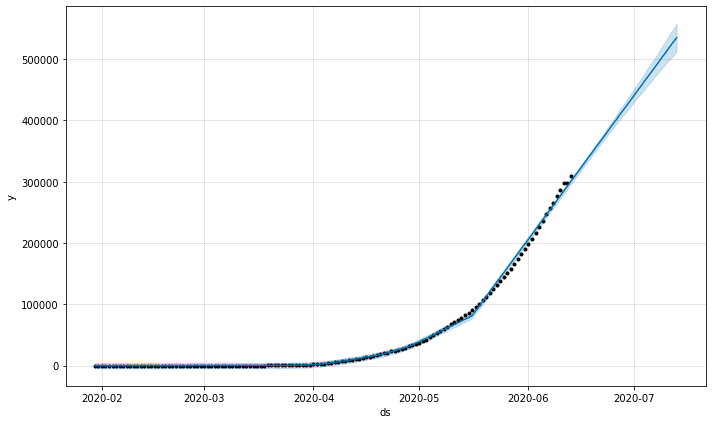

In [45]:
from fbprophet.plot import plot_plotly
fig1 =prophet_basic.plot(forecast)